## Reconstrucción DPC

Reconstrucción de imágenes según Diferencial Phase Contrast (DPC). Prueba de diferentes métodos.

In [2]:
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy
# from scipy import misc, signal, optimize
from numpy.fft import fft2, ifft2, fftshift, ifftshift

import pyfpm.fpmmath as fpm
import pyfpm.solvertools as st

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Cargo una imagen de prueba para hacer las pruebas, y luego grafico una funcion de transferencia (una pupila). La idea es recortar la pupila para tener una aproximación más pequeña con la que se pueda trabajar con más facilidad.

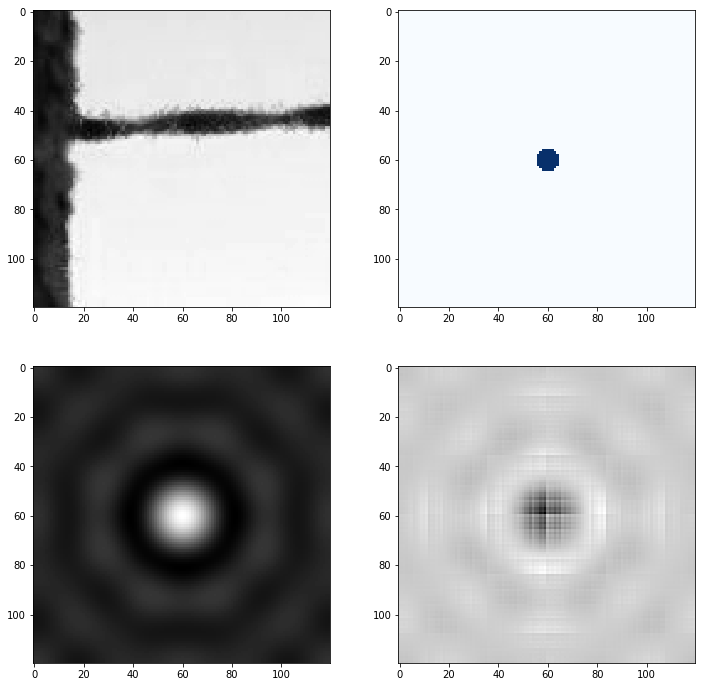

In [95]:
pany, panx = [200, 320]
npx = 120
alambre = scipy.misc.imread('alambre.png', 'F')[pany:pany+npx, panx:panx+npx]
# Creo una transferencia que consiste en una pupila circular y un desenfoque
rpup = 5
# AP = fpm.aberrated_pupil(image_size=[npx, npx], pupil_radius=rpup, aberrations=[0, ],
#                     pixel_size=2E-6, wavelength=522E-9)
AP = fpm.simple_defocus(image_size=[npx, npx], pupil_radius=rpup, aberrations=[.5E-4, ],
                    pixel_size=2E-6, wavelength=522E-9)
# P = fpm.create_source_pattern(shape='semicircle', ledmat_shape=[n, n], radius=r)
H = fftshift(fft2(fftshift(AP)))

fig, (axes1, axes2) = plt.subplots(2, 2, figsize=(12, 12))
axes1[0].imshow(alambre)
axes1[1].imshow(np.real(AP), cmap = cm.Blues)
axes2[0].imshow(np.real(H))
axes2[1].imshow(np.imag(H))
plt.show()

Recorto la pupila para quedarme con un recuadro de NH píxeles de lado. El tamaño del recuadro será, en principio,  inversamente proporcional al radio de la pupila.

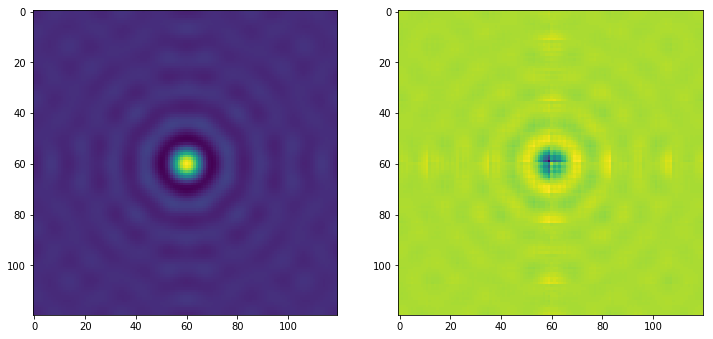

In [4]:
Hcy, Hcx = fpm.image_center(np.shape(H))
NH = npx
H_cut = H[Hcy-NH//2:Hcy+NH//2, Hcx-NH//2:Hcx+NH//2]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(np.real(H_cut))
axes[1].imshow(np.imag(H_cut))
plt.show()

Ya teniendo la función de transferencia aproximada puedo armar la matriz de convolución 'A'. Tengo implementada esta función en pyfpm.solvertools. Luego, aplicar el filtro simplemente es efectuar el producto A*I.ravel().

1.7 s en armar la matrix de 14400 x  14400.


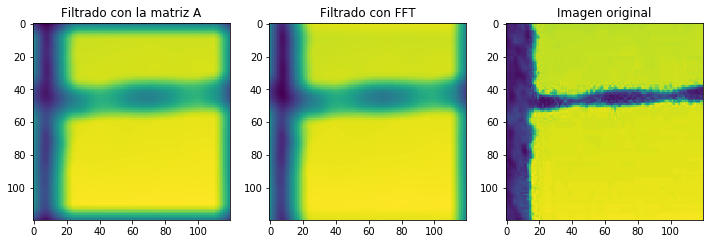

In [5]:
start = time.time()
A = st.make_convolution_matrix(alambre, kernel=AP, debug=True)
print('%.1f s en armar la matrix de %i x % i.' % (time.time()-start, npx**2, npx**2))
alambre_A = A*alambre.ravel()
alambre_A = alambre_A.reshape(npx, npx)
alambre_F = ifft2(fftshift(fft2(alambre))*H)
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(np.abs(alambre_A)), axes[0].set_title('Filtrado con la matriz A')
axes[1].imshow(np.abs(alambre_F)), axes[1].set_title('Filtrado con FFT')
axes[2].imshow(alambre), axes[2].set_title('Imagen original')

plt.show()

Resuelvo ahora el problema de cuadrados mínimos regularizado según Tikhonov. Según las pruebas iniciales nl_solve() parece estar andando más rápido que sparse_solve().

20.8 s para el problema de dimensiones 14400 x  14400.


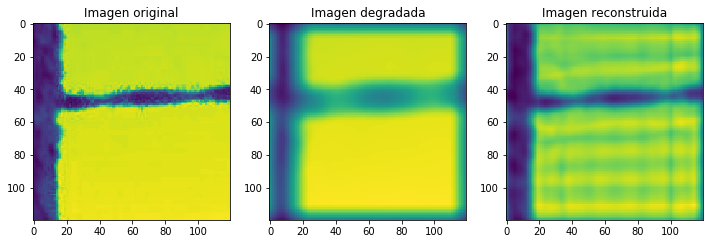

In [7]:
start = time.time()
xhat = st.nl_solve(A, alambre_A.ravel(), lm=0.006)
print('%.1f s para el problema de dimensiones %i x % i.' % (time.time()-start, npx**2, npx**2))
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(alambre), axes[0].set_title('Imagen original')
axes[1].imshow(np.real(alambre_A)), axes[1].set_title('Imagen degradada')
axes[2].imshow(np.real(xhat.reshape(npx, npx))), axes[2].set_title('Imagen reconstruida')
plt.show()

Repito las pruebas con una imagen obtenida con el microscopio. Promero pruebo la recomposición de colores RGB.

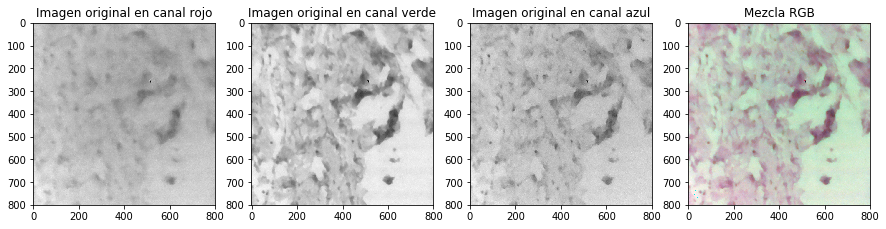

In [181]:
def rescale_color(image, offset=0):
    
    image -= image.min()
    image /= image.max()
    return image+offset

npx = 150
pany, panx = [1300, 1460]
rb = np.load('../out_sampling/20180725_172307.npy')[()][0][pany:pany+npx, panx:panx+npx]
gb = np.load('../out_sampling/20180725_170647.npy')[()][0][pany:pany+npx, panx:panx+npx]
bb = np.load('../out_sampling/20180725_172601.npy')[()][0][pany:pany+npx, panx:panx+npx]

nr = np.sum(rb)/1E5
ng = np.sum(gb)/1E5
nb = np.sum(bb)/1E5

npx = 800
pany, panx = [800, 800]
mic_red = np.load('../out_sampling/20180725_172307.npy')[()][0][pany:pany+npx, panx:panx+npx]
mic_green = np.load('../out_sampling/20180725_170647.npy')[()][0][pany:pany+npx, panx:panx+npx]
mic_blue = np.load('../out_sampling/20180725_172601.npy')[()][0][pany:pany+npx, panx:panx+npx]
rgbArray[..., 0] = rescale_color(mic_red, offset=0.0)*1.05
rgbArray[..., 1] = rescale_color(mic_green,offset=0.0)
rgbArray[..., 2] = rescale_color(mic_blue, offset=0.0)
mic_red = rescale_color(mic_red)


fig, axes = plt.subplots(1, 4, figsize=(15, 6))
axes[0].imshow(mic_red), axes[0].set_title('Imagen original en canal rojo')
axes[1].imshow(mic_green), axes[1].set_title('Imagen original en canal verde')
axes[2].imshow(mic_blue), axes[2].set_title('Imagen original en canal azul')
axes[3].imshow(rgbArray), axes[3].set_title('Mezcla RGB')
plt.show()

8.8 s para el problema de dimensiones 14400 x  14400.


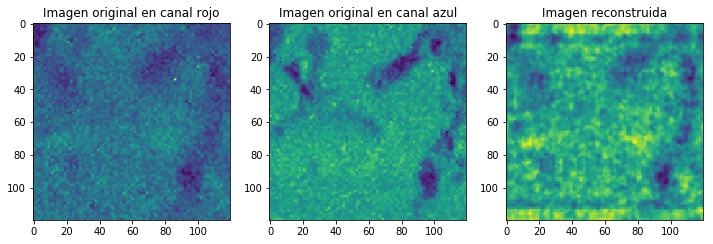

In [84]:
start = time.time()
rpup = 7
AP = fpm.simple_defocus(image_size=[npx, npx], pupil_radius=rpup,
                        aberrations=[.5E-4, ], pixel_size=2E-6, wavelength=522E-9)
A = st.make_convolution_matrix(alambre, kernel=AP, debug=True)
xhat = st.nl_solve(A, mic_red.ravel(), lm=0.05)
print('%.1f s para el problema de dimensiones %i x % i.' % (time.time()-start, npx**2, npx**2))
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(mic_red), axes[0].set_title('Imagen original en canal rojo')
axes[1].imshow(mic_blue), axes[1].set_title('Imagen original en canal azul')
axes[2].imshow(np.real(xhat.reshape(npx, npx))), axes[2].set_title('Imagen reconstruida')
plt.show()

In [ ]:
Test usando Richardson-Lucy de Skimage. es mucho más rápido, pero más ruidoso.

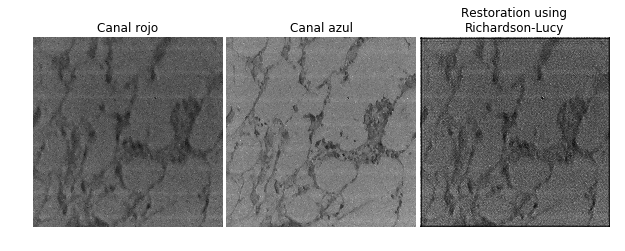

In [119]:
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration

# astro = color.rgb2gray(data.astronaut())
mic_image = mic_red

psf = AP

AP = fpm.simple_defocus(image_size=[npx, npx], pupil_radius=5,
                        aberrations=[.5E-4, ], pixel_size=2E-6, wavelength=522E-9)
# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(mic_image, AP, iterations=20)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(mic_image)
ax[0].set_title('Canal rojo')

ax[1].imshow(mic_blue)
ax[1].set_title('Canal azul')


ax[2].imshow(deconvolved_RL, vmin=mic_image.min(), vmax=mic_image.max())
ax[2].set_title('Restoration using\nRichardson-Lucy')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()

In [171]:
nr

18.329676666666671